In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

In [2]:
# 問題1,2,3,4,5,6
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        self.best_sse = 9999999

        init_cluster_column = np.zeros(X.shape[0], dtype=int).reshape(X.shape[0], 1)
        for n_init_iter in range(self.n_init):
            self.centers = X[np.random.choice(len(X),size=self.n_clusters, replace=False)]
            X_with_cluster = np.concatenate([X, init_cluster_column], 1)
            for i in range(self.max_iter):
                self._update_clusters(X_with_cluster)
                self._update_centers(X_with_cluster)
                self._calc_sse(X_with_cluster)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("{}回初期値を変更, {}回目: SSE: {}".format(n_init_iter, i, self.best_sse))
                # 全ての中心の移動距離の合計がtol以下であれば終了
                if self.total_move_distance < self.tol:
                    print("全ての中心の移動距離の合計が{}以下になったため終了".format(self.tol))
                    break

    def _calc_sse(self, X):
        _sse = 0
        for X_value in X:
            _sse += self._calc_distance(X_value[:-1], self.centers[int(X_value[-1])])

        if self.best_sse > _sse:
            self.best_centers = self.centers
            self.best_sse = _sse
    
    def _update_clusters(self, X):
        for X_index, X_value in enumerate(X):
            _nearest_value = 9999999
            for center_label, center in enumerate(self.centers):
                _distance = self._calc_distance(X_value[:-1], center)
                if _nearest_value > _distance:
                    _nearest_value = _distance
                    X[X_index, -1] = center_label

    def _update_centers(self, X):
        # この変数に各中心がどれだけ移動したか記録
        self.total_move_distance = 0
        for center_label, center in enumerate(self.centers):
            X_cluster_n = X[X[:, -1] == center_label]
            new_center_n = np.average(X_cluster_n[:,:-1], axis=0)
            self.total_move_distance += self._calc_distance(new_center_n, self.centers[center_label])
            self.centers[center_label] = new_center_n

    def _calc_distance(self, X_value, center):
#         return np.sqrt(((X_value - center) ** 2).sum())
        return np.linalg.norm(X_value - center)

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        pred_y = np.zeros(X.shape[0]).reshape(X.shape[0], 1)
        for X_index, X_value in enumerate(X):
#             print("X_index: {},X_value: {} ".format(X_index, X_value))
            _nearest_value = 9999999
            for center_label, center in enumerate(self.best_centers):
#                 print("checking... : center_label: {}".format(center_label))
                _distance = self._calc_distance(X_value, center)
                if _nearest_value > _distance:
#                     print("_distance: {}, center_label: {}, center: {}".format(_distance, center_label, center))
                    _nearest_value = _distance
                    pred_y[X_index] = center_label

        return pred_y

def display_plot(X, model):
    pred_y = model.predict(X)
    pred_df = pd.DataFrame({'f0': X[:,0], 'f1': X[:,1], 'class': pred_y.T[0]})
    df = pd.DataFrame({'f0': X[:,0], 'f1': X[:,1], 'class': pred_y.T[0]})
    plt.figure(figsize=(5, 5))
    plt.xlim(-3,10)
    plt.ylim(-3,10)
    
    sns.scatterplot(x='f0', y='f1', hue='class', data=df)
    plt.scatter(km.best_centers[:,0], km.best_centers[:,1], marker="x", c="red")

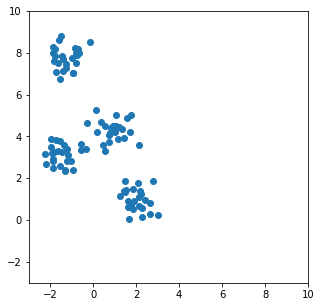

In [3]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
plt.figure(figsize=(5, 5))
plt.xlim(-3,10)
plt.ylim(-3,10)
plt.scatter(X[:,0], X[:,1], label="data")

0回初期値を変更, 0回目: SSE: 185.13791400339701
0回初期値を変更, 1回目: SSE: 185.13791400339701
0回初期値を変更, 2回目: SSE: 185.13791400339701
0回初期値を変更, 3回目: SSE: 185.13791400339701
0回初期値を変更, 4回目: SSE: 185.13791400339701


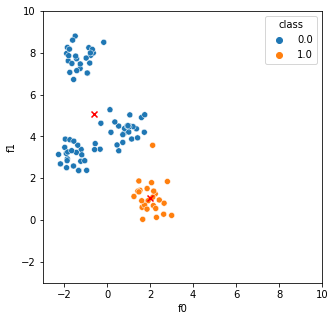

In [4]:
# 問題7 cluster 2
km = ScratchKMeans(2, 1, 5, 0, verbose=True)
km.fit(X)
display_plot(X, km)

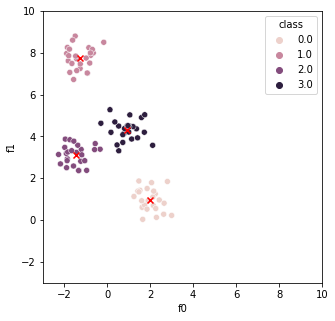

In [5]:
# 問題7 cluster 4
km = ScratchKMeans(4, 100, 10, 0, verbose=False)
km.fit(X)
display_plot(X, km)

In [6]:
# 問題8
elbow = {}
for n_cluster in range(1, 10, 1):
    km = ScratchKMeans(n_cluster, 10, 10, 0, verbose=False)
    km.fit(X)
    elbow[n_cluster] = km.best_sse

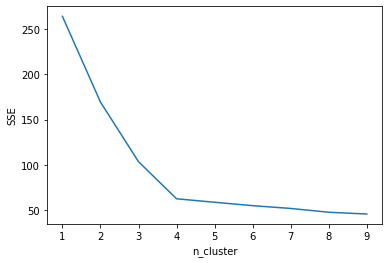

In [7]:
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.xlabel('n_cluster')
plt.ylabel('SSE')
plt.show()

#### 考察
4から収束、plotを見ても4分割が妥当そう

In [8]:
# 問題9
from matplotlib import cm

def calc_silhouette_vals(X, pred_y, centers):
    nearest_cluster_dict = {}
    for i, i_center in enumerate(centers):
        _nearest_distance = 999999
        _nearest_cluster_index = None
        for k, k_center in enumerate(centers):
            if i == k:
                continue
                _distance = np.linalg.norm(i_center - k_center)
                if _nearest_distance > _distance:
                    _nearest_distance = _distance
                    _nearest_cluster_index = k
        nearest_cluster_dict[i] = _nearest_cluster_index
    
    a_list = []
    for X_index, X_value in enumerate(X):
        X_cluster = X[pred_y == pred_y[X_index]]
        a_n = np.sum(list(map(np.linalg.norm, X_cluster - X_value))) / len(X_cluster)
        a_list.append(a_n)
        
    b_list = []
    for X_index, X_value in enumerate(X):
        X_cluster = X[pred_y == nearest_cluster_dict[pred_y[X_index]]]
        b_n = np.sum(list(map(np.linalg.norm, X_cluster - X_value))) / len(X_cluster)
        b_list.append(a_n)
        
    s_list = []
    for X_index, X_value in enumerate(X):
        s_n = (b_list[X_index] - a_list[X_index]) / np.array(b_list[X_index], a_list[X_index]).max()
        s_list.append(s_n)
    return s_list

def display_silhouette(silhouette_vals, silhouette_avg, y_km, cluster_labels, n_clusters):
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

In [9]:
km = ScratchKMeans(4, 100, 10, 0, verbose=False)
km.fit(X)
pred_y = km.predict(X)

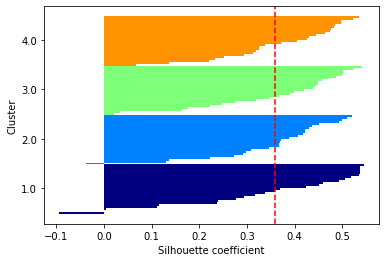

In [10]:
pred_y_T = pred_y.T[0]
silhouette_vals = calc_silhouette_vals(X, pred_y_T, km.best_centers)
display_silhouette(np.array(silhouette_vals), np.average(np.array(silhouette_vals)), pred_y_T, np.unique(pred_y_T), len(np.unique(pred_y_T)))

In [11]:
df = pd.read_csv("data/Wholesale customers data.csv")

In [12]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [13]:
df.shape

(440, 8)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [15]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [16]:
df_products = df.drop(["Channel", "Region"], axis=1)

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


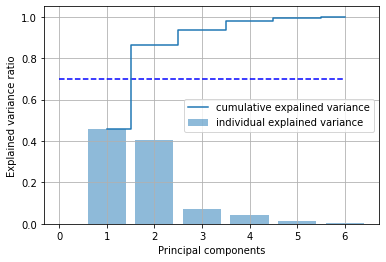

In [17]:
# PCAの分散説明率
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(df_products)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df_products)
data_pca = pca.transform(df_products)

In [19]:
pd.DataFrame(data=pca.components_, columns=df_products.columns)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.976537,0.121184,0.061540,0.152365,-0.007054,0.068105
1,-0.110614,0.515802,0.764606,-0.018723,0.365351,0.057079


上より
第1主成分は Freshの影響が高い
第2主成分は Milk, Grocery, Detergents_Paperの影響が高い

<AxesSubplot:xlabel='f0', ylabel='f1'>

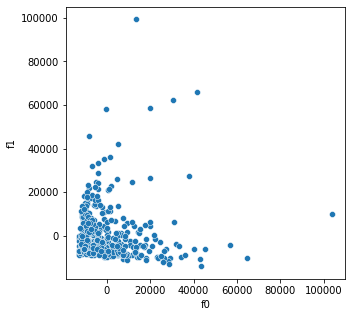

In [20]:
# plot
plt.figure(figsize=(5, 5))
plot_df = pd.DataFrame({'f0': data_pca[:,0], 'f1': data_pca[:,1]})
sns.scatterplot(x='f0', y='f1', data=plot_df)

#### 考察

- 0,0以下の辺りに偏っている。
- 外れ値がf0, v1ともいくつかあり、グループ数が多いと外れ値のみを含むグループが発生しそう。


In [21]:
elbow = {}
for n_cluster in range(1, 11, 1):
    km = ScratchKMeans(n_cluster, 10, 20, 0, verbose=False)
    km.fit(data_pca)
    elbow[n_cluster] = km.best_sse

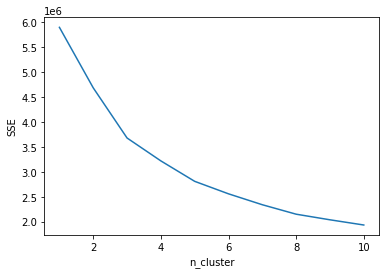

In [22]:
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.xlabel('n_cluster')
plt.ylabel('SSE')
plt.show()

In [23]:
def display_wholesale_data_plot(X, model):
    pred_y = model.predict(X)
    plot_pred_df = pd.DataFrame({'f0': X[:,0], 'f1': X[:,1], 'class': pred_y.T[0]})
    plt.figure(figsize=(5, 5))
    
    sns.scatterplot(x='f0', y='f1', hue='class', data=plot_pred_df)
    plt.scatter(model.best_centers[:,0], model.best_centers[:,1], marker="x", c="red")

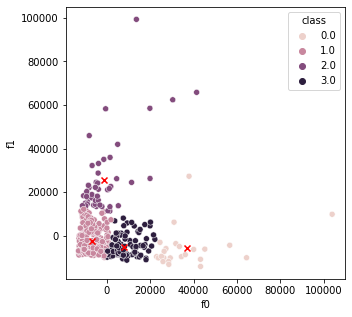

In [24]:
# 4分割
km = ScratchKMeans(4, 10, 20, 0, verbose=False)
km.fit(data_pca)
display_wholesale_data_plot(data_pca, km)

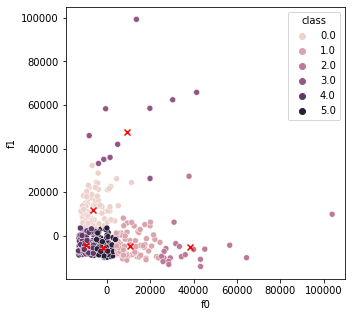

In [25]:
# 6分割
km = ScratchKMeans(6, 10, 10, 0, verbose=False)
km.fit(data_pca)
display_wholesale_data_plot(data_pca, km)

#### 考察
- 複数外れ値があるので、クラスタは分割すればするほどSSEの値は下がりそう。
- プロットずを見ると、4でも6でも分割できていることがわかるので、それぞれの分割単位でそれぞれの意味が見出せる可能性がある。

In [26]:
# 問題11
# 4分割の値を利用して検証
km_c4 = ScratchKMeans(4, 10, 20, 0, verbose=False)
km_c4.fit(data_pca)
pred_y = km_c4.predict(data_pca)

In [27]:
def display_classified_wholesale_data_plot(X, column_name):
    plot_pred_df = pd.DataFrame({'f0': X[:,0], 'f1': X[:,1], column_name: df[column_name]})
    plt.figure(figsize=(5, 5))
    
    sns.scatterplot(x='f0', y='f1', hue=column_name, data=plot_pred_df)

### データについて

データは卸売業者の客の商品カテゴリ別の年間支出

Channel, Regionはグループ、その他は年間の支出を示す

### Channelについて

1がHoreca(で298), 2がRetail(144)の2種類。
Horecaとはhotel, restaurant, cafeteriaの略で飲食店向けの販売を示す
Retailは小売り

### Regionについて

1がLisbon(77), 2がOporto(47), 3がOther Region(316)の3種類。
※ただし、Other Regionの割合が多いのでregionによる特徴は見るべきなのかは要確認

### Channelとk-meansでの分割を比較

Channelの分割数に合わせて分割し、分割のされ方を比較する。

In [28]:
pd.set_option('display.max_columns', 100)
df.drop(["Region"], axis=1).groupby("Channel").agg(['mean', 'max', 'min'])

Fresh                      Milk                   Grocery  \
                 mean     max min          mean    max  min          mean   
Channel                                                                     
1        13475.560403  112151   3   3451.724832  43950   55   3962.137584   
2         8904.323944   44466  18  10716.500000  73498  928  16322.852113   

                           Frozen            Detergents_Paper              \
           max   min         mean    max min             mean    max  min   
Channel                                                                     
1        21042     3  3748.251678  60869  25       790.560403   6907    3   
2        92780  2743  1652.612676  11559  33      7269.507042  40827  332   

          Delicassen             
                mean    max min  
Channel                          
1        1415.956376  47943   3  
2        1753.436620  16523   3

#### Channelの違いによる傾向

- 1はFresh, Frozenがの平均高い
- 2はMilk(極端に), Grocery, Detergents_Paper(極端に), Delicassen(やや)が高い

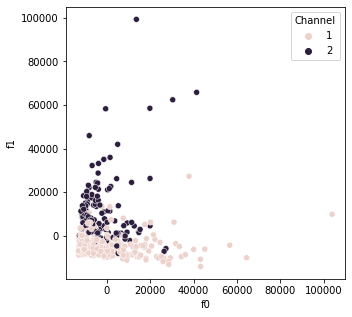

In [29]:
display_classified_wholesale_data_plot(data_pca, "Channel")

In [30]:
# k-meansで2分割
km_c2 = ScratchKMeans(2, 10, 20, 0, verbose=False)
km_c2.fit(data_pca)
pred_c2_y = km_c2.predict(data_pca)
df["class"] = pred_c2_y
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean', 'max', 'min'])

Fresh                        Milk                   Grocery  \
               mean     max    min         mean    max  min          mean   
class                                                                       
0.0    35401.369231  112151  16117  9514.230769  73498  286  10346.369231   
1.0     7944.112000   23257      3  5151.818667  29892   55   7536.128000   

                        Frozen            Detergents_Paper             \
         max  min         mean    max min             mean    max min   
class                                                                   
0.0    92780  471  6463.092308  60869  42      2933.046154  40827  10   
1.0    67298    3  2484.130667  35009  25      2872.557333  38102   3   

        Delicassen             
              mean    max min  
class                          
0.0    3316.846154  47943   3  
1.0    1214.261333  14472   3

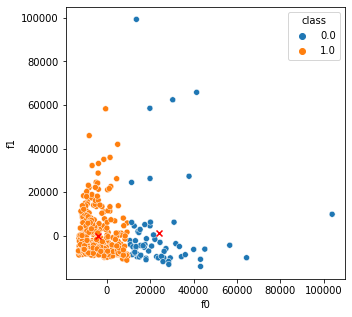

In [31]:
display_wholesale_data_plot(data_pca, km_c2)

### channelとk-means (n_cluster=2)による分割の比較

channelはおおよそf1の値を境に分割されてるが、
k-meansはf0(第一主成分)の値を境に分割されてる。

channelと第2主成分は相関がありそう。

In [32]:
display("改めて主成分の固有ベクトル")
pd.DataFrame(data=pca.components_, columns=df_products.columns)

'改めて主成分の固有ベクトル'

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.976537,0.121184,0.061540,0.152365,-0.007054,0.068105
1,-0.110614,0.515802,0.764606,-0.018723,0.365351,0.057079


In [33]:
df["class"] = pred_c2_y
df.drop(["Region"], axis=1).groupby(["Channel", "class"]).agg(['mean'])

Fresh          Milk       Grocery       Frozen  \
                       mean          mean          mean         mean   
Channel class                                                          
1       0.0    37190.901961   5930.666667   5820.980392  7615.196078   
        1.0     8578.870445   2939.878543   3578.327935  2949.813765   
2       0.0    28882.357143  22568.642857  26831.714286  2266.142857   
        1.0     6719.226562   9420.171875  15173.445312  1585.507812   

              Detergents_Paper   Delicassen  
                          mean         mean  
Channel class                                
1       0.0         684.529412  3128.960784  
        1.0         812.453441  1062.259109  
2       0.0       11124.071429  4001.285714  
        1.0        6847.914062  1507.578125

Channel別での分類結果は、Detergents_Paper以外は同じような偏りを示している。

### Regionとk-meansでの分割を比較

Regionの分割数に合わせて分割し、分割のされ方を比較する。

In [34]:
df.drop(["Channel"], axis=1).groupby("Region").agg(['mean', 'max', 'min'])

Fresh                     Milk                  Grocery         \
                mean     max min         mean    max  min         mean    max   
Region                                                                          
1       11101.727273   56083  18  5486.415584  28326  258  7403.077922  39694   
2        9887.680851   32717   3  5088.170213  25071  333  9218.595745  67298   
3       12533.471519  112151   3  5977.085443  73498   55  7896.363924  92780   

                   Frozen             Detergents_Paper             \
         min         mean    max  min             mean    max min   
Region                                                              
1        489  3000.337662  18711   61      2651.116883  19410   5   
2       1330  4045.361702  60869  131      3687.468085  38102  15   
3          3  2944.594937  36534   25      2817.753165  40827   3   

         Delicassen                class            
               mean    max min      mean  max  min  
Region                                              
1       1354.896104   6854   7  0.870130  1.0  0.0  
2       1159.702128   5609  51  0.914894  1.0  0.0  
3       1620.601266  47943   3  0.838608  1.0  0.0

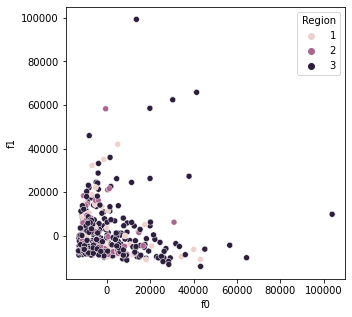

In [35]:
display_classified_wholesale_data_plot(data_pca, "Region")

#### Regionの違いによる傾向

- 商品によってどのregionが大きいなどはあるが、大きな差はない
- 散文図から見ても主成分では分割できていないように見える。
- また、大変のデータが3のothersなのでRegion毎に傾向があるという判断は母数の少なさより、なんとも言えない。

In [36]:
# k-meansで3分割
km_c3 = ScratchKMeans(3, 10, 20, 0, verbose=False)
km_c3.fit(data_pca)
pred_c3_y = km_c3.predict(data_pca)
df["class"] = pred_c3_y
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean', 'max', 'min'])

Fresh                         Milk                    Grocery  \
               mean     max    min          mean    max   min          mean   
class                                                                         
0.0     8249.996960   22686      3   3800.966565  18664    55   5248.556231   
1.0    35941.400000  112151  22096   6044.450000  43950   286   6288.616667   
2.0     8027.411765   44466     85  18375.921569  73498  3737  27342.549020   

                          Frozen             Detergents_Paper              \
         max    min         mean    max  min             mean    max  min   
class                                                                       
0.0    22272      3  2571.677812  35009   25      1755.112462  10069    3   
1.0    20170    471  6713.966667  60869  127      1039.666667   5058   10   
2.0    92780  13567  2014.313725  10155   33     12314.607843  40827  282   

        Delicassen             
              mean    max min  
class                          
0.0    1137.018237  14472   3  
1.0    3049.466667  47943   3  
2.0    2233.254902  16523   3

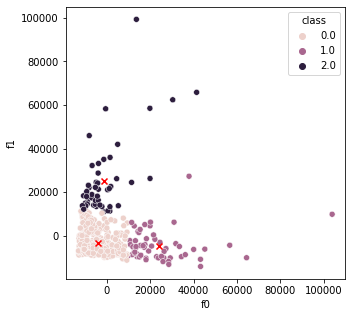

In [37]:
display_wholesale_data_plot(data_pca, km_c3)

In [38]:
df["class"] = pred_c3_y
df.drop(["Channel"], axis=1).groupby(["Region", "class"]).agg(['mean'])

Fresh          Milk       Grocery        Frozen  \
                      mean          mean          mean          mean   
Region class                                                           
1      0.0     7704.625000   3807.339286   4557.625000   2486.178571   
       1.0    33635.636364   4342.090909   5556.181818   5216.818182   
       2.0     5338.200000  16148.000000  25369.200000   3441.500000   
2      0.0     8708.457143   3047.257143   5338.600000   3228.142857   
       1.0    28852.750000   7380.750000   8790.000000  16912.250000   
       2.0     5564.250000  12870.875000  26407.875000   1187.250000   
3      0.0     8310.899160   3910.306723   5397.886555   2495.256303   
       1.0    37135.133333   6341.800000   6245.311111   6173.422222   
       2.0     9439.454545  20385.606061  28167.121212   1782.333333   

             Detergents_Paper   Delicassen  
                         mean         mean  
Region class                                
1      0.0        1595.446429  1100.321429  
       1.0         501.272727  2111.636364  
       2.0       10927.700000  1948.100000  
2      0.0        1578.342857  1043.828571  
       1.0        1473.500000  2239.250000  
       2.0       14021.875000  1126.875000  
3      0.0        1818.676471  1159.357143  
       1.0        1132.711111  3350.733333  
       2.0       12321.000000  2587.878788

region毎の分類の傾向は、region 1,2がほぼ同じで3のfreshのみ異なる傾向を示している。

### regionとk-means (n_cluster=3)による分割の比較

- regionは主成分分析の主成分においては分割が見えない
- k-meansは、f0, f1共に小さいもの、f0が大きいもの、 f1が大きいものに分割された。

In [39]:
# 問題12
# まずは様々な値で分析してみる

# 検証1 Group以外の項目が6つあるので6つで分割してみる
km_c6 = ScratchKMeans(6, 10, 20, 0, verbose=False)
km_c6.fit(data_pca)
pred_c6_y = km_c6.predict(data_pca)
df["class"] = pred_c6_y
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean', 'max', 'min'])

Fresh                         Milk                    Grocery  \
               mean     max    min          mean    max   min          mean   
class                                                                         
0.0    15073.983607   23257   8533   2943.524590  17972   134   3970.401639   
1.0     4287.258427   10362      3   3609.792135  18664    55   4594.247191   
2.0     5466.581081   26373     18  12443.527027  36423  1266  19295.594595   
3.0    31039.918367   45640  22096   5300.428571  16784   286   5924.734694   
4.0    61227.100000  112151  36847  10157.400000  43950   555   8532.800000   
5.0    20031.285714   44466     85  38084.000000  73498  4980  56126.142857   

                           Frozen              Detergents_Paper                \
         max    min          mean    max   min             mean    max    min   
class                                                                           
0.0    14982      3   3516.991803  35009   118       941.409836   6707      3   
1.0    16483    137   2126.264045  17866    47      1521.101124   7271      5   
2.0    36486  10487   1679.648649  10155    25      8470.081081  18906    282   
3.0    16966    471   5605.510204  60869   127      1019.938776   5058     10   
4.0    20170    902  12718.600000  36534  3012      1197.400000   4948    212   
5.0    92780  32114   2564.571429   7782    36     27644.571429  40827  19410   

        Delicassen              
              mean    max  min  
class                           
0.0    1140.032787   3628   51  
1.0    1013.174157   7844    3  
2.0    2045.459459  16523    3  
3.0    2230.326531  14351    3  
4.0    7302.700000  47943  818  
5.0    2548.142857   6465  903

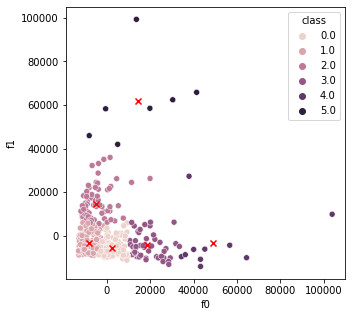

In [40]:
display_wholesale_data_plot(data_pca, km_c6)

In [41]:
# 検証2 region, channel含めて分割する
km_c6_all = ScratchKMeans(6, 10, 20, 0, verbose=False)
km_c6_all.fit(df.values)
pred_c6_all_y = km_c6_all.predict(df.values)
df["class"] = pred_c6_all_y
df.groupby(["class"]).agg(['mean'])

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
,mean,mean,mean,mean,mean,mean,mean,mean
class,,,,,,,,
0.0,1.175000,2.575000,14971.133333,2712.525000,3768.008333,3399.016667,862.441667,1097.608333
1.0,1.000000,2.461538,56453.307692,10026.230769,8739.000000,15518.076923,1258.230769,7170.538462
2.0,1.906667,2.520000,5434.986667,12334.013333,19258.093333,1664.920000,8360.360000,2045.920000
3.0,2.000000,2.571429,20031.285714,38084.000000,56126.142857,2564.571429,27644.571429,2548.142857
4.0,1.203390,2.508475,4292.898305,3720.163842,4564.146893,2232.293785,1541.135593,1029.858757
5.0,1.208333,2.645833,30042.000000,5091.770833,5993.750000,4252.000000,1139.312500,1925.979167


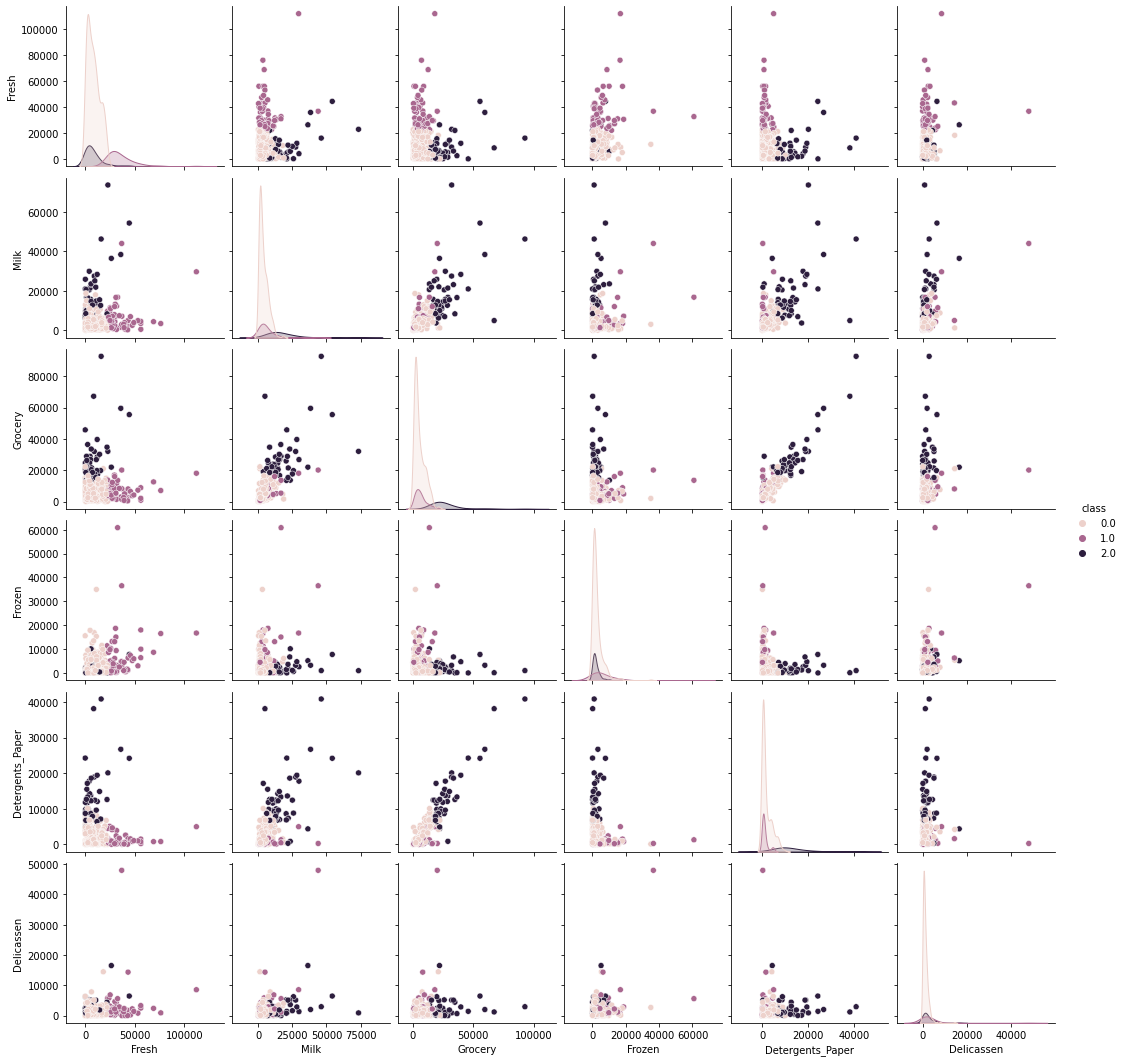

In [42]:
# 3分割した際のpairplot
df["class"] = pred_c3_y
sns.pairplot(df.drop(["Channel", "Region"], axis=1), hue='class')

In [43]:
# 検証4 総支出額という特徴量を加えて分類してみる。
from sklearn.decomposition import PCA
df_products_with_total = pd.concat([df_products, pd.Series(df_products.sum(axis=1), name="total")], axis=1)
pca_with_total = PCA(n_components = 2)
pca_with_total = pca_with_total.fit(df_products_with_total)
data_pca_with_total = pca_with_total.transform(df_products_with_total)

In [44]:
pd.DataFrame(data=pca_with_total.components_, columns=df_products_with_total.columns)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,total
0,0.257130,0.195599,0.241226,0.061859,0.103431,0.046697,0.905942
1,0.802458,-0.254587,-0.462535,0.121591,-0.247983,0.010873,-0.030182


f1はtotalが最も強く反映される。

In [45]:
# k-meansで3分割
km_c3_with_total = ScratchKMeans(3, 10, 20, 0, verbose=False)
km_c3_with_total.fit(data_pca_with_total)
pred_c3_y_with_total = km_c3.predict(data_pca_with_total)
df["class"] = pred_c3_y_with_total
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean', 'max', 'min'])

Fresh                         Milk                    Grocery  \
               mean     max    min          mean    max   min          mean   
class                                                                         
0.0     7475.131833   21273      3   3803.765273  18664    55   5257.389068   
1.0    19707.426966  112151     85  14273.415730  73498  1266  19661.932584   
2.0    30035.100000   56159  19219   2426.300000  11006   134   2840.050000   

                         Frozen             Detergents_Paper             \
         max   min         mean    max  min             mean    max min   
class                                                                     
0.0    22272   137  2392.115756  17866   25      1763.022508  10069   3   
1.0    92780  2062  5289.865169  60869   33      7885.022472  40827  20   
2.0     8280     3  3422.600000  13223  127       444.750000   2587   3   

        Delicassen             
              mean    max min  
class                          
0.0    1069.778135   7844   3  
1.0    3196.202247  47943   3  
2.0    1344.500000   4626  18

'各商品の支出の合計を特徴量を加えると別の分類ができた。'

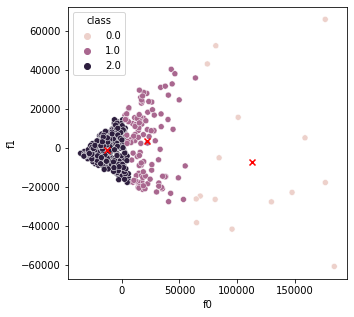

In [46]:
display_wholesale_data_plot(data_pca_with_total, km_c3_with_total)
display("各商品の支出の合計を特徴量を加えると別の分類ができた。")

#### 有益な情報1

問題11でわかったようにregion, channelの分類と各商品の支出額での分類は異なっていたことから、
一部の商品の支出額はregionと相関があるものの、それ以外にも各商品の支出額あげる要素は別にあるということが示唆される。

#### 有益な情報2

以下のように2分割した場合、全ての商品に対して支出額が大きいものと小さいものに分けることができた。
これは、既存のregionやchannelにはないグループを作成することができたと言える。
これに顧客情報を組み合わせれば、全ての商品に対する支出額の高い、または低いユーザーはどんなユーザーかというという分析に利用できると考えられる。

In [47]:
df["class"] = pred_c2_y
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean'])

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
,mean,mean,mean,mean,mean,mean
class,,,,,,
0.0,35401.369231,9514.230769,10346.369231,6463.092308,2933.046154,3316.846154
1.0,7944.112000,5151.818667,7536.128000,2484.130667,2872.557333,1214.261333


### 問題13

##### DBSCAN

メリット
- クラスタ数を決めなくてもいい
- クラスタが球状でなくても分類できる

デメリット
- パラメータの調整がデータがわからないと難しい。データの密集度によってパラメータの微調整も必要

#### t-SNE

メリット
- 非線形な関係のあるデータに有効
- 2,3次元への圧縮に有効なので可視化が得意
- PCAに比べて同じクラスのデータ間の分布が近くなる傾向がある

デメリット
- 2,3次元への圧縮には有効だが、それ以上ではうまくいかない可能性がある
- 類似度は正規分布に

#### LLE

メリット
- 非線形な関係のあるデータに有効

デメリット
- k-meansを利用しており、kが大きいと近傍でないものも含まれることがある。

In [48]:
# 問題14
# t-SNEを利用
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
data_tsne = tsne.fit_transform(df_products)

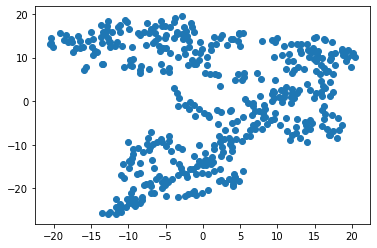

In [49]:
plt.scatter(data_tsne[:,0], data_tsne[:,1], label="data")
plt.show()

In [50]:
# k-meansで3分割
tsne_km_c3 = ScratchKMeans(3, 10, 20, 0, verbose=False)
tsne_km_c3.fit(data_tsne)
tsne_pred_c3_y = tsne_km_c3.predict(data_tsne)
df["class"] = tsne_pred_c3_y
display("t-SNEの場合")
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean', 'max', 'min'])

't-SNEの場合'

Fresh                         Milk                    Grocery  \
               mean     max    min          mean    max   min          mean   
class                                                                         
0.0     5980.785185   44466      9  11757.385185  73498  1275  17175.748148   
1.0    25731.481203  112151  13146   3956.180451  29627   134   5165.127820   
2.0     6107.197674   13265      3   2540.337209  18664    55   2865.546512   

                         Frozen             Detergents_Paper             \
         max   min         mean    max  min             mean    max min   
class                                                                     
0.0    92780  4748  1793.696296  36534   25      7533.037037  40827  93   
1.0    21042     3  4441.593985  60869  118      1072.751880   6707   3   
2.0     7647   137  3016.098837  35009   47       629.191860   4762   3   

        Delicassen             
              mean    max min  
class                          
0.0    2039.066667  47943   3  
1.0    1788.721805  14472   3  
2.0     917.261628   5137   3

In [51]:
display("PCAの場合")
df["class"] = pred_c3_y
df.drop(["Channel", "Region"], axis=1).groupby(["class"]).agg(['mean', 'max', 'min'])

'PCAの場合'

Fresh                         Milk                    Grocery  \
               mean     max    min          mean    max   min          mean   
class                                                                         
0.0     8249.996960   22686      3   3800.966565  18664    55   5248.556231   
1.0    35941.400000  112151  22096   6044.450000  43950   286   6288.616667   
2.0     8027.411765   44466     85  18375.921569  73498  3737  27342.549020   

                          Frozen             Detergents_Paper              \
         max    min         mean    max  min             mean    max  min   
class                                                                       
0.0    22272      3  2571.677812  35009   25      1755.112462  10069    3   
1.0    20170    471  6713.966667  60869  127      1039.666667   5058   10   
2.0    92780  13567  2014.313725  10155   33     12314.607843  40827  282   

        Delicassen             
              mean    max min  
class                          
0.0    1137.018237  14472   3  
1.0    3049.466667  47943   3  
2.0    2233.254902  16523   3

#### 考察

##### t-SNE

- class 0: Milk, Grocery, Detergents_Paper, Delicassenが大きいものがおい, ただしFreshが最も少ない
- class 1: Fresh, Frozenの大きいものが多い。
- class 2: 他のclassに比べて全体的に少ないものが多い。

##### PCA
    
- class 0: Milk, Grocery, Detergents_Paperが大きいものがおい, ただしFreshが最も少ない
- class 1: 他のclassに比べて全体的に少ないものが多い。
- class 2: Fresh, Frozen, Delicassenの大きいものが多い。
    
いくつかの大小は異なる。

'PCAとtSNEで大分分布が異なる, ただしPCAもL字っぽい形をしてたので向きは違うが分布は似ていそう'

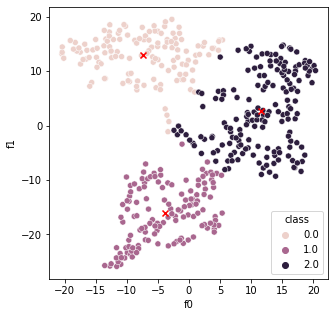

In [52]:
display_wholesale_data_plot(data_tsne, tsne_km_c3)
display("PCAとtSNEで大分分布が異なる, ただしPCAもL字っぽい形をしてたので向きは違うが分布は似ていそう")

'eps, min_samplesを色々変えたが、結果出ず'

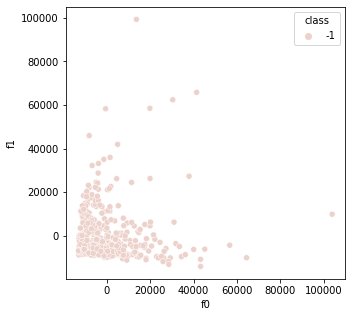

In [53]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=10).fit(data_pca)
plot_pred_df = pd.DataFrame({'f0': data_pca[:,0], 'f1':data_pca[:,1], 'class': dbscan.labels_})
plt.figure(figsize=(5, 5))
sns.scatterplot(x='f0', y='f1', hue='class', data=plot_pred_df)
display("eps, min_samplesを色々変えたが、結果出ず")